# TRAINING A CLASSIFIER FOR CIFAR DATASET USING CONVOLUTION NEURAL NETWORK
In this assignment we will be creating convolution neural network model for classification 
of cifar dataset. 

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
 
The resolution of the images are 28*28.
We will be using [Pytorch](https://pytorch.org/) for this task.

## Required packages for this assignment

[*] torch

[*] torchvision

[*] numpy 

[*] matplotlib

[*] sklearn


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.cuda.current_device()
torch.cuda.is_available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)


cuda:0


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          #shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         #shuffle=False, num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Put the dataset into the torch Dataloader
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
                                         

# Let us show some training images

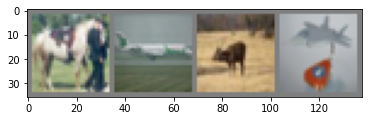

horse plane  deer plane


In [ ]:
#Let us show some of the training images,

import matplotlib.pyplot as plt
import numpy as np

#functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# # get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# # print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Define convolution neural network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, padding = (2,2))
        self.conv2 = nn.Conv2d(64, 128, 5, padding = (2,2))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding = (1,1))
        self.conv4 = nn.Conv2d(256, 512, 3, padding = (1,1))
        self.conv5 = nn.Conv2d(512, 1024, 3, padding = (1,1))
        self.conv6 = nn.Conv2d(1024, 2048, 3, padding = (1,1))
        self.fc1 = nn.Linear(2048*4*4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.pool(F.relu(self.conv2(x)))
      x = F.relu(self.conv3(x))
      x = self.pool(F.relu(self.conv4(x)))
      x = F.relu(self.conv5(x))
      x = self.pool(F.relu(self.conv6(x)))
      x = x.view(-1,2048*4*4)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))     
      x = self.fc3(x)
      return x
    
    def get_layer_embeds(self, num, x):
        if num == 1:
            return self.conv1(x)
        elif num == 2:
            return self.pool(self.conv1(x))
        elif num == 3:
            return self.conv2(x)
        elif num == 4:
            return self.pool(self.conv2(x))
    
net = Net()
net.to('cuda')

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

# Define a loss function and optimizer

In [ ]:
# Define a Loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# train the network

In [ ]:
for epoch in range(5):  #loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.236
[1,  6000] loss: 1.989
[1,  8000] loss: 1.832
[1, 10000] loss: 1.699
[1, 12000] loss: 1.602
[2,  2000] loss: 1.465
[2,  4000] loss: 1.406
[2,  6000] loss: 1.337
[2,  8000] loss: 1.260
[2, 10000] loss: 1.206
[2, 12000] loss: 1.121
[3,  2000] loss: 0.983
[3,  4000] loss: 0.951
[3,  6000] loss: 0.920
[3,  8000] loss: 0.856
[3, 10000] loss: 0.868
[3, 12000] loss: 0.810
[4,  2000] loss: 0.667
[4,  4000] loss: 0.672
[4,  6000] loss: 0.653
[4,  8000] loss: 0.649
[4, 10000] loss: 0.635
[4, 12000] loss: 0.637
[5,  2000] loss: 0.438
[5,  4000] loss: 0.463
[5,  6000] loss: 0.479
[5,  8000] loss: 0.477
[5, 10000] loss: 0.460
[5, 12000] loss: 0.460
Finished Training


# save the model

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

################FEATURE MAPS of CLASS NAME :cat ############### 


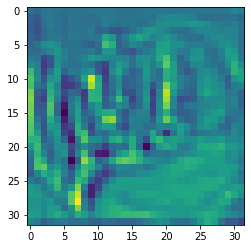

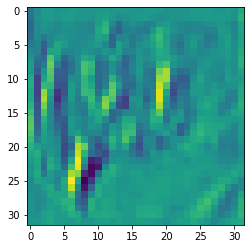

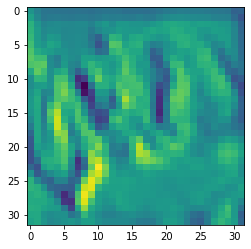

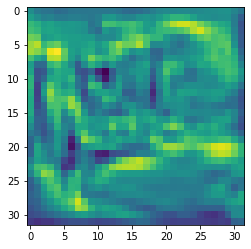

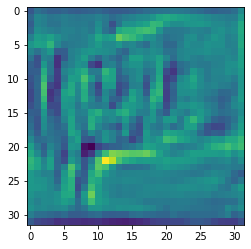

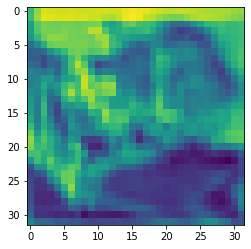

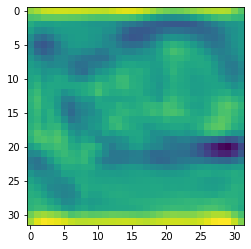

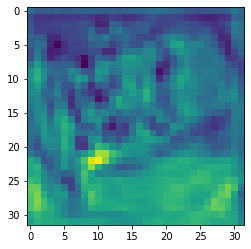

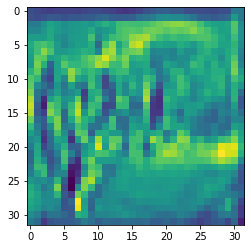

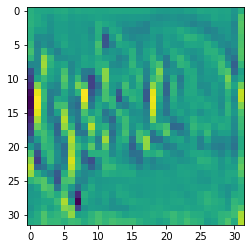

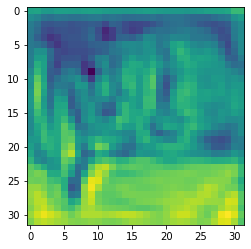

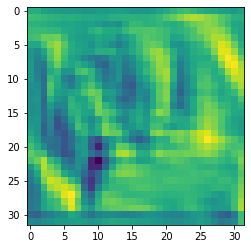

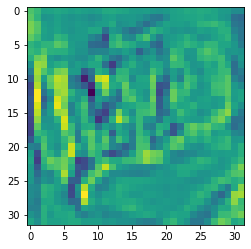

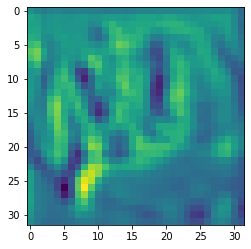

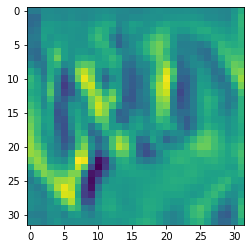

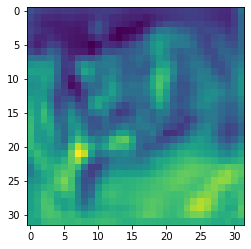

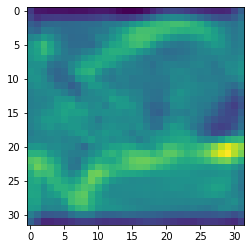

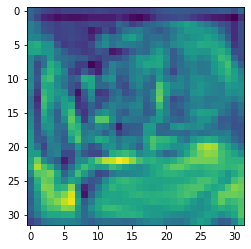

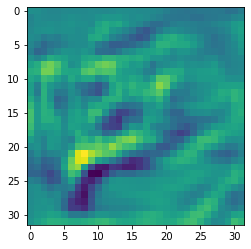

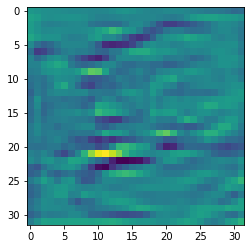

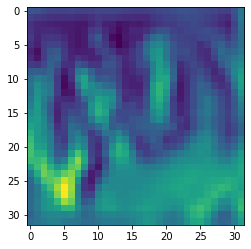

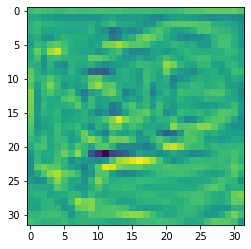

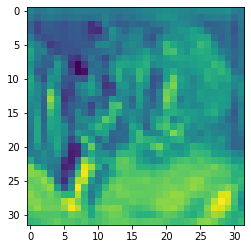

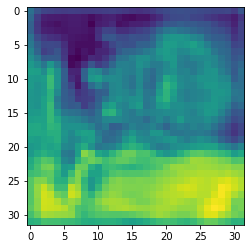

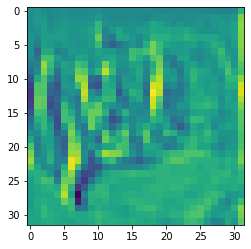

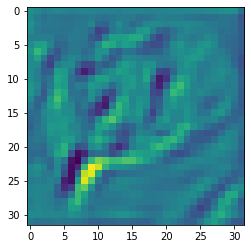

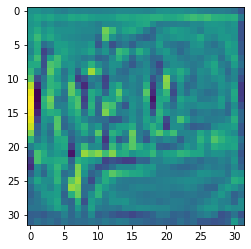

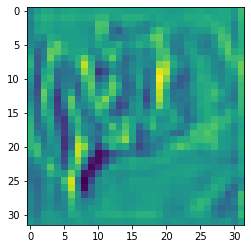

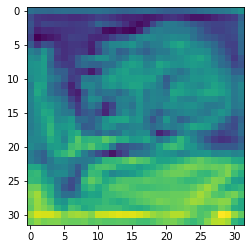

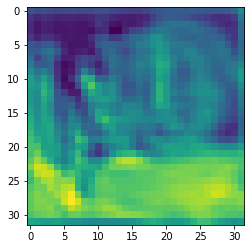

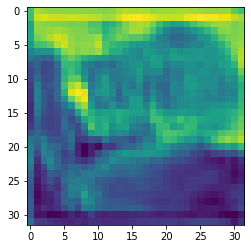

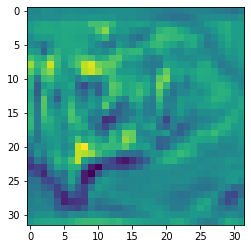

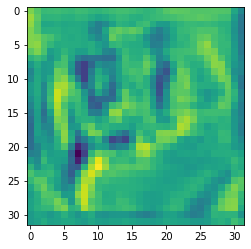

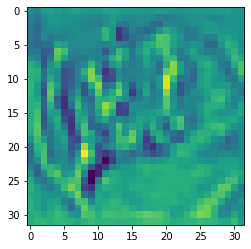

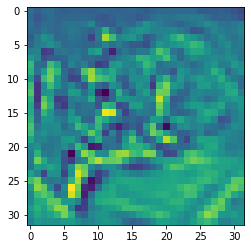

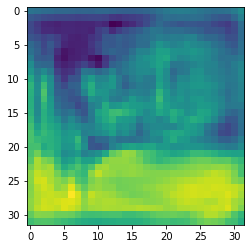

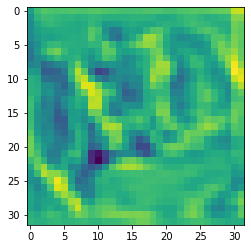

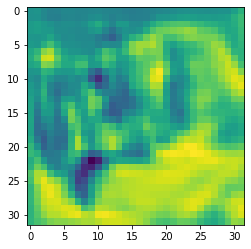

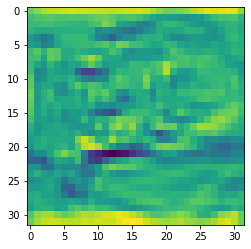

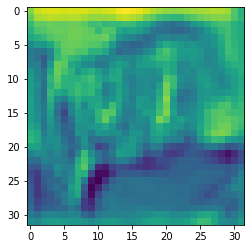

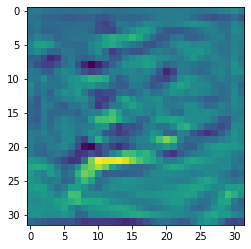

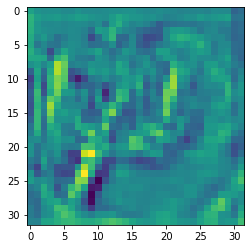

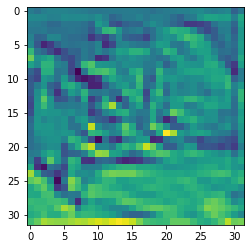

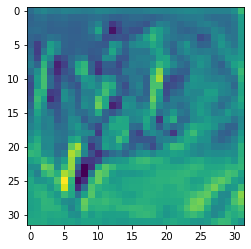

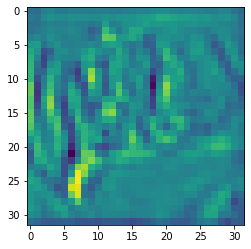

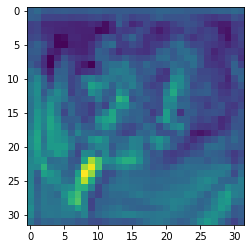

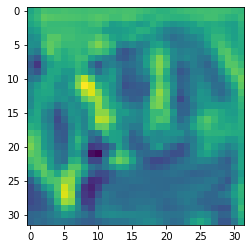

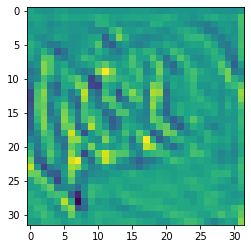

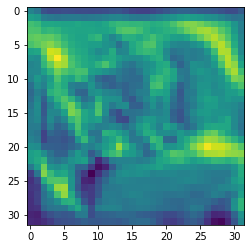

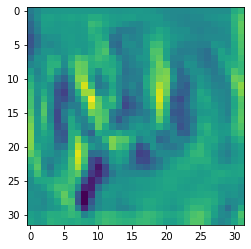

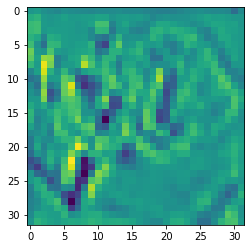

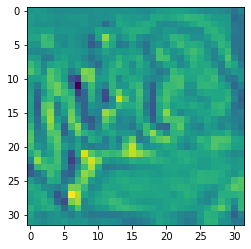

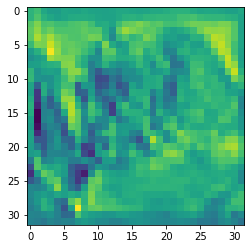

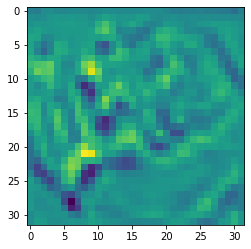

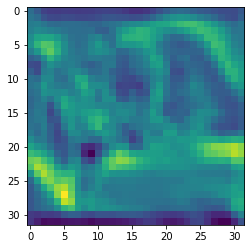

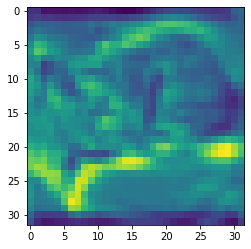

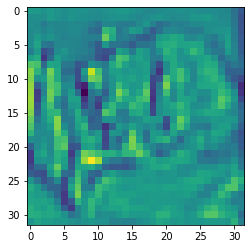

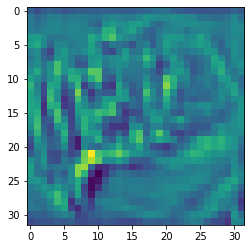

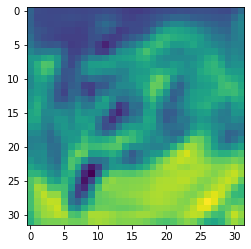

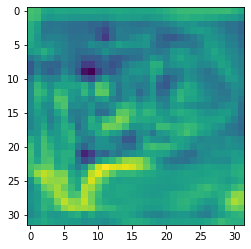

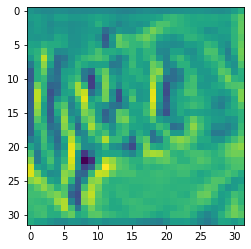

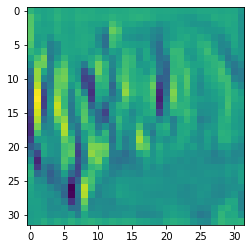

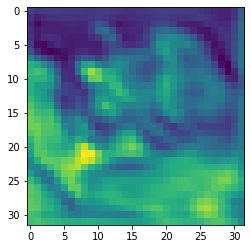

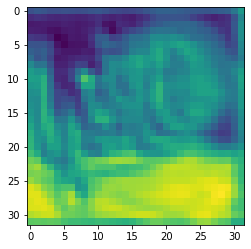

################FEATURE MAPS of CLASS NAME :ship ############### 


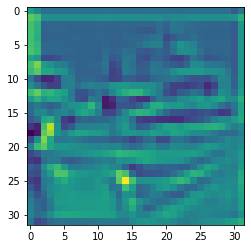

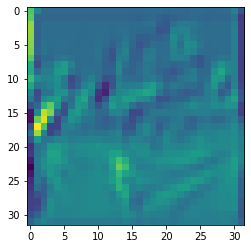

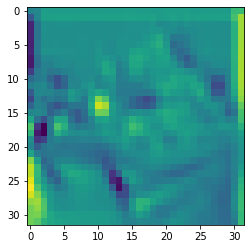

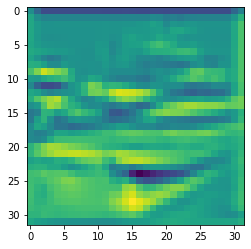

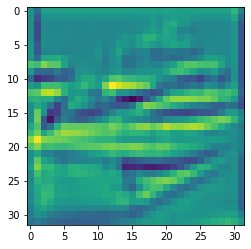

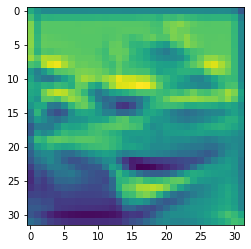

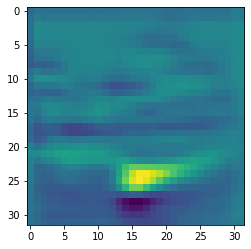

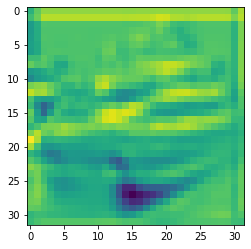

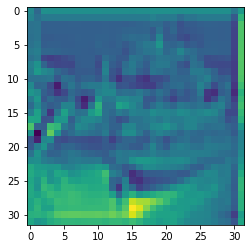

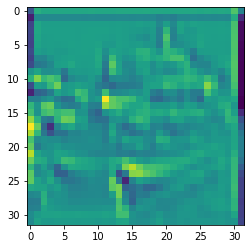

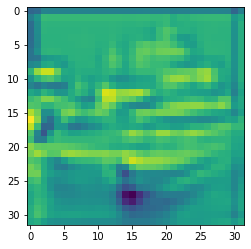

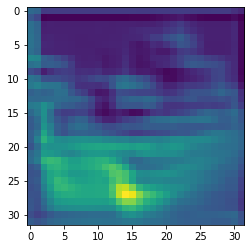

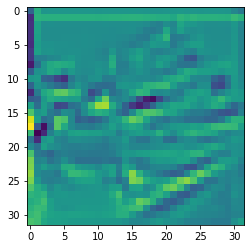

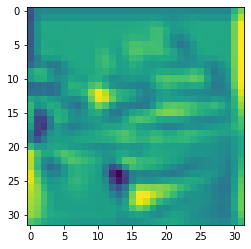

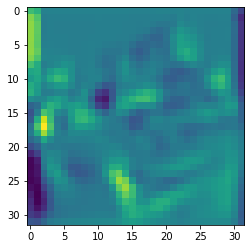

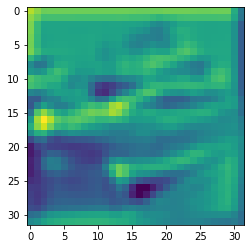

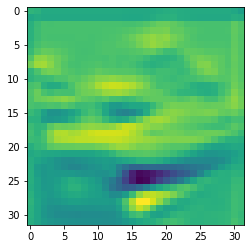

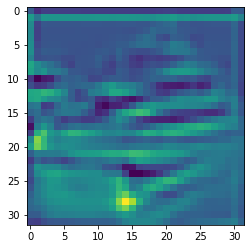

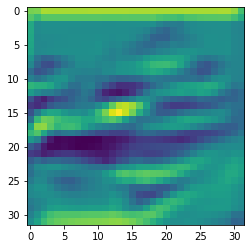

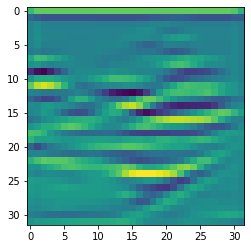

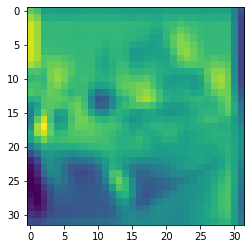

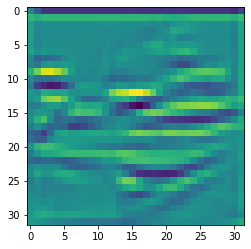

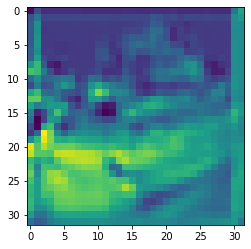

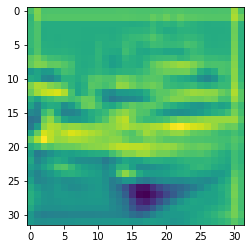

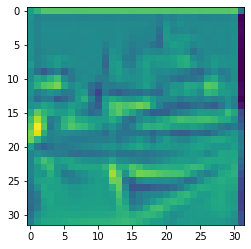

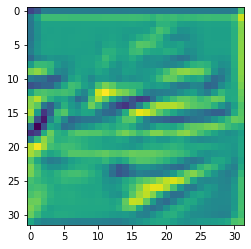

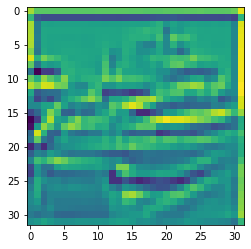

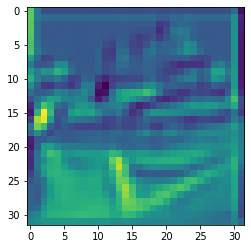

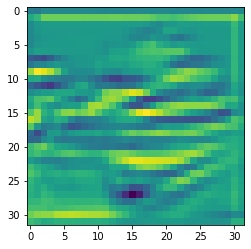

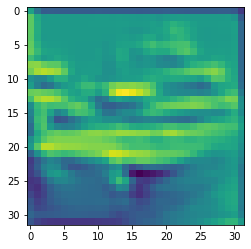

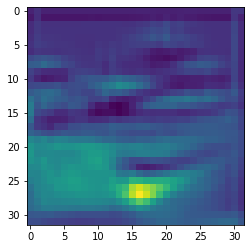

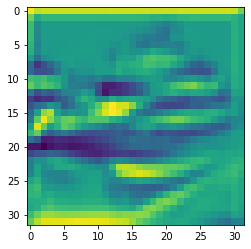

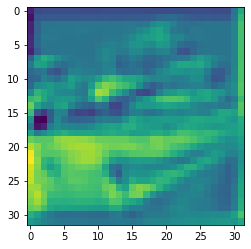

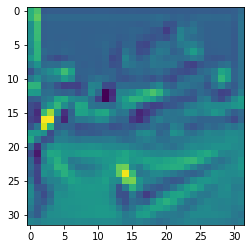

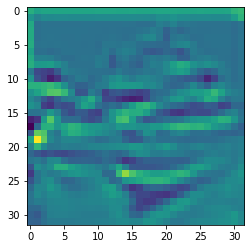

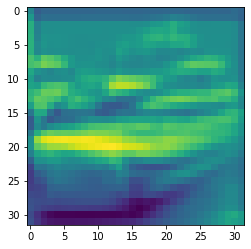

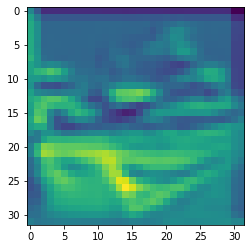

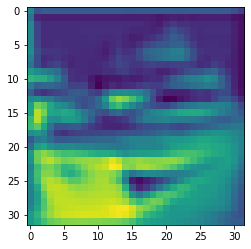

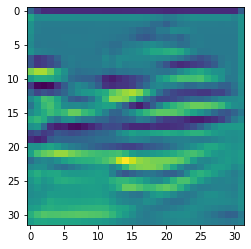

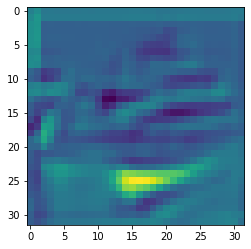

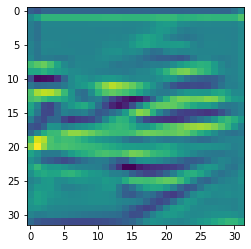

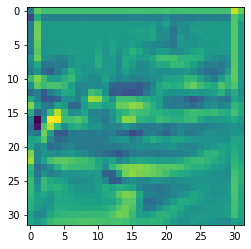

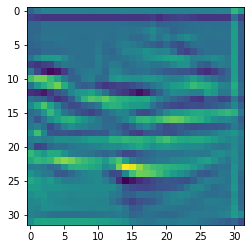

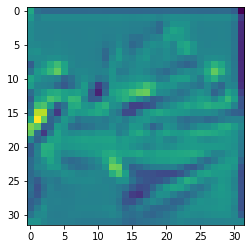

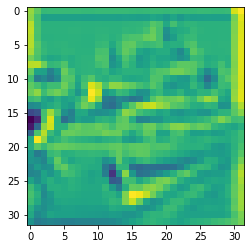

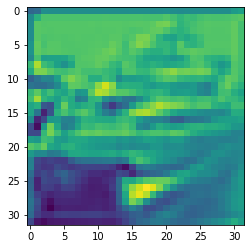

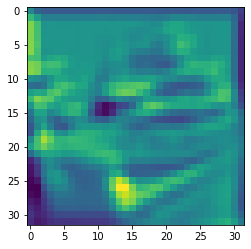

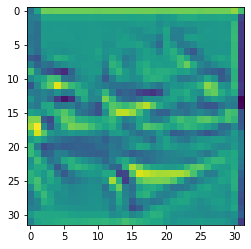

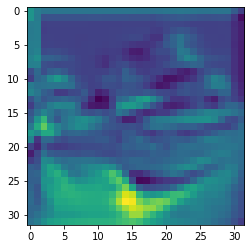

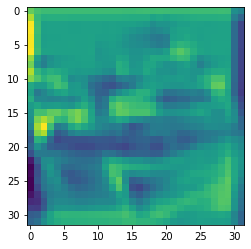

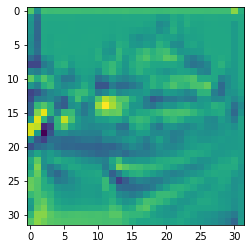

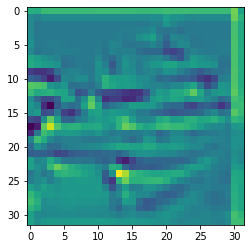

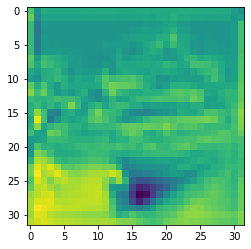

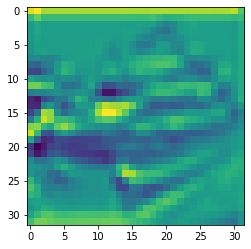

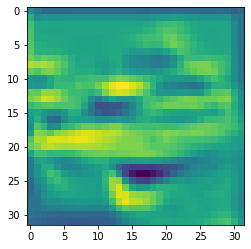

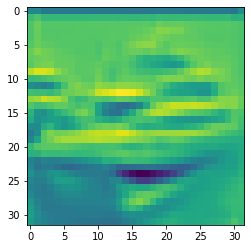

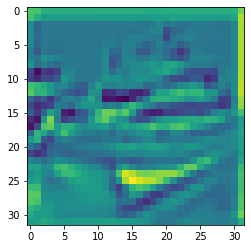

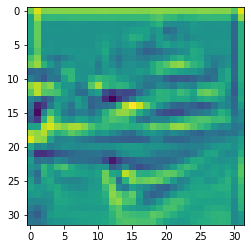

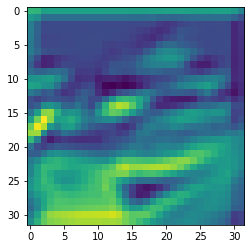

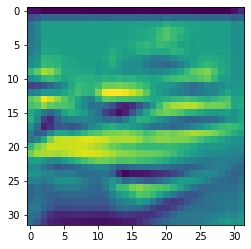

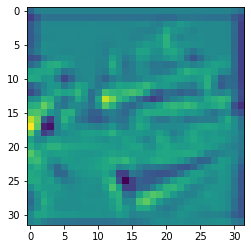

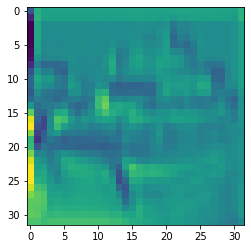

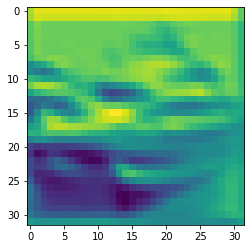

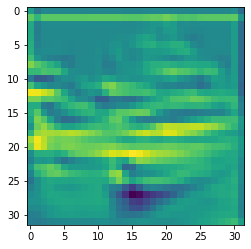

################FEATURE MAPS of CLASS NAME :ship ############### 


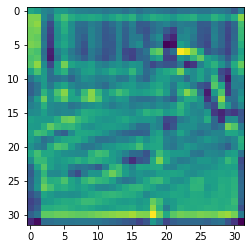

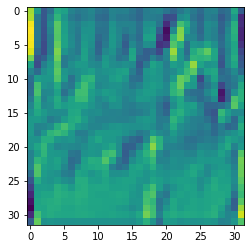

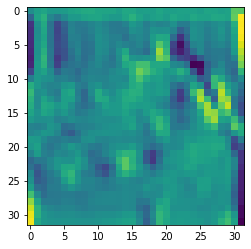

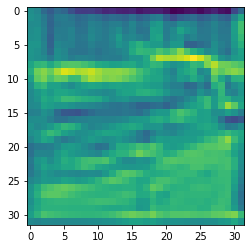

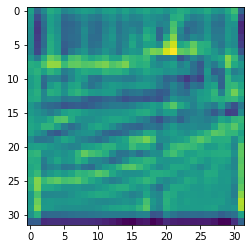

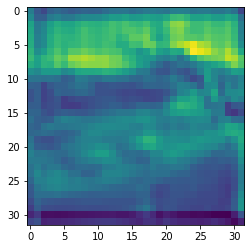

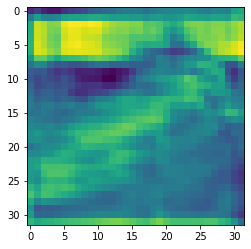

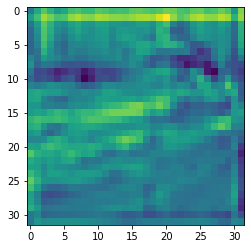

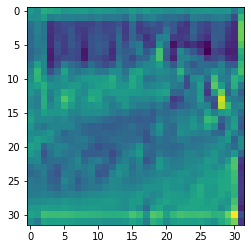

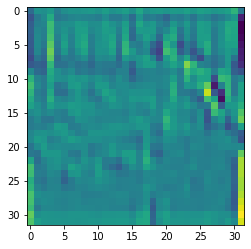

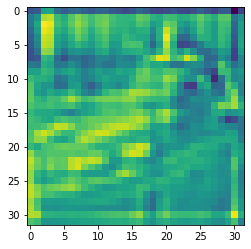

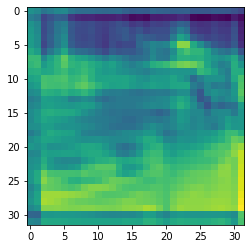

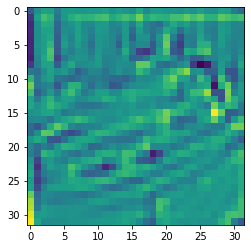

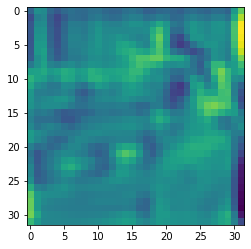

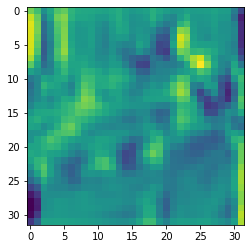

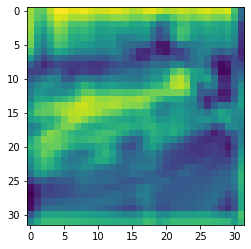

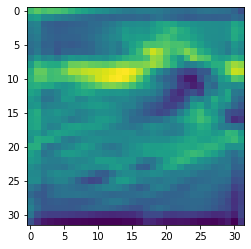

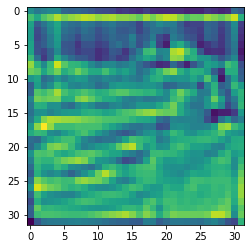

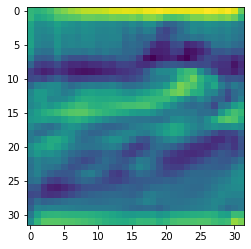

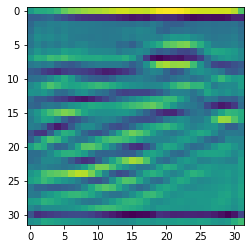

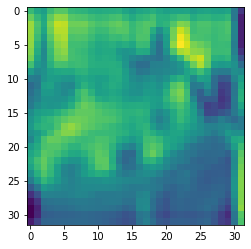

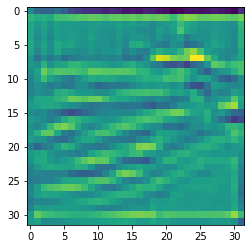

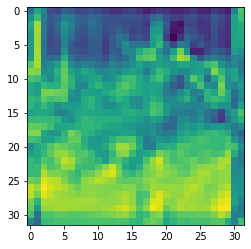

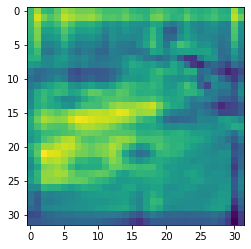

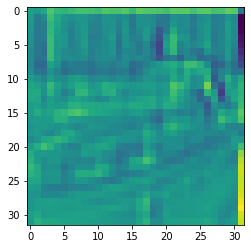

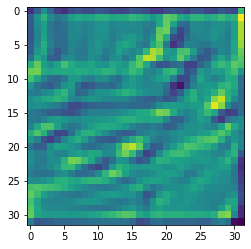

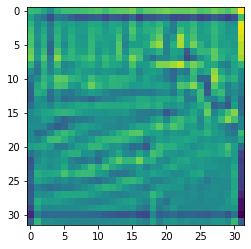

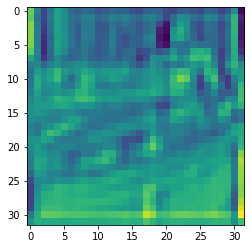

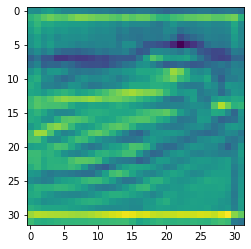

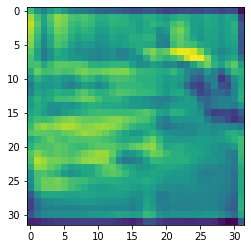

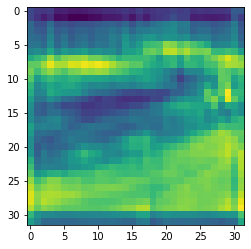

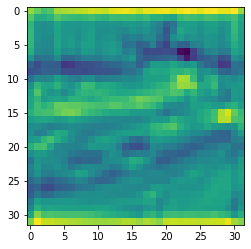

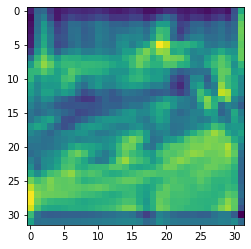

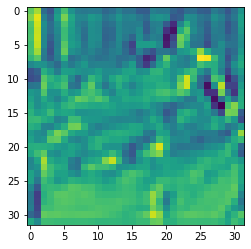

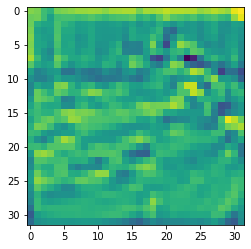

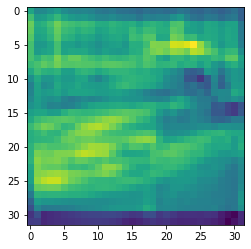

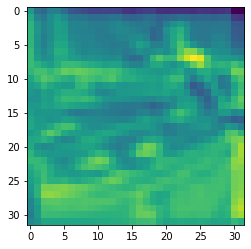

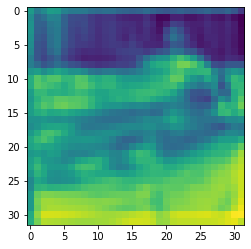

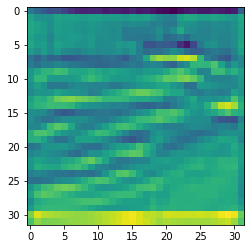

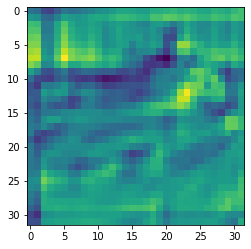

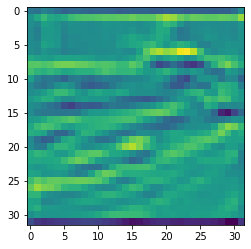

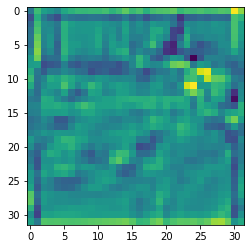

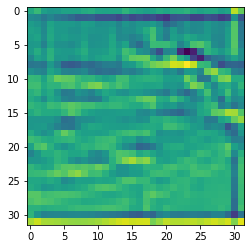

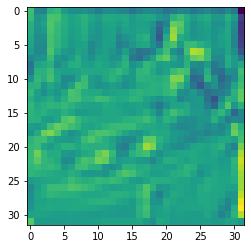

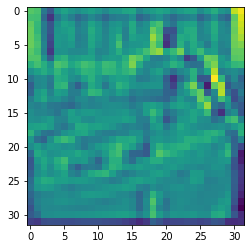

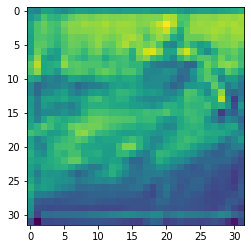

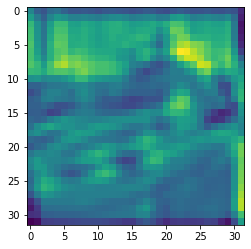

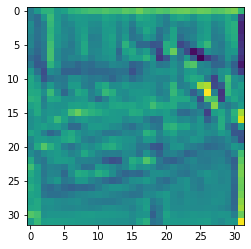

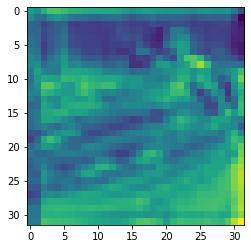

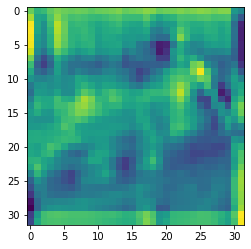

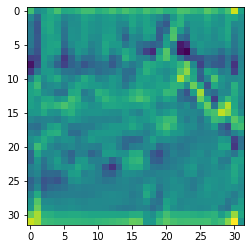

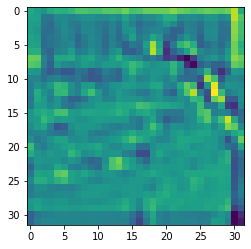

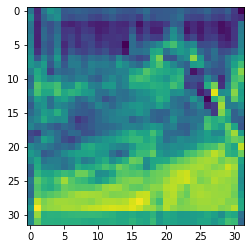

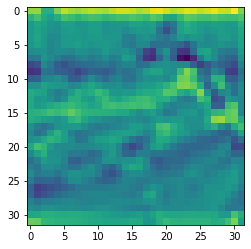

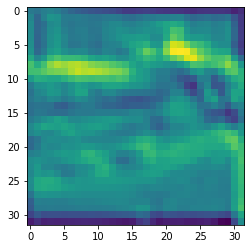

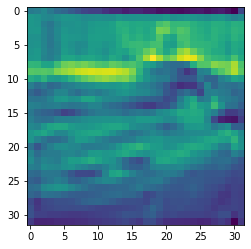

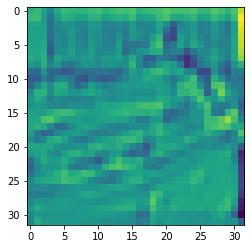

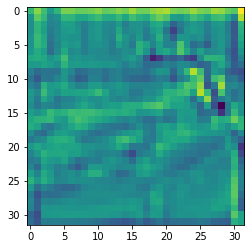

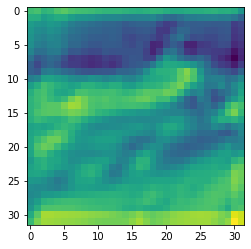

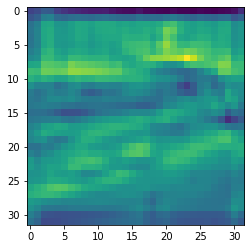

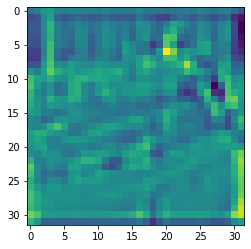

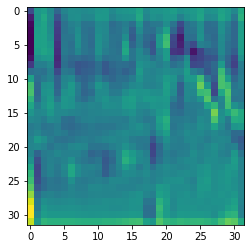

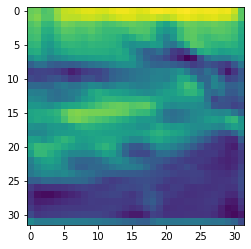

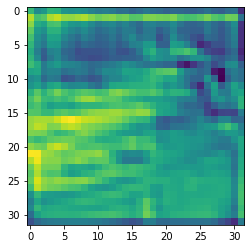

################FEATURE MAPS of CLASS NAME :plane ############### 


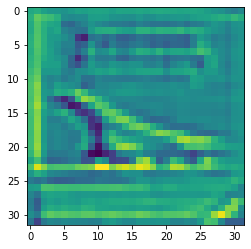

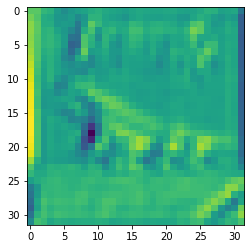

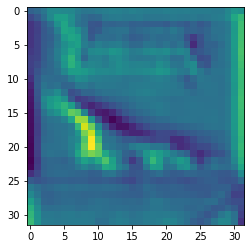

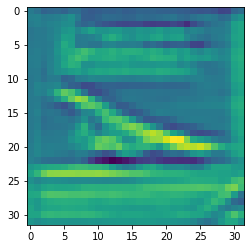

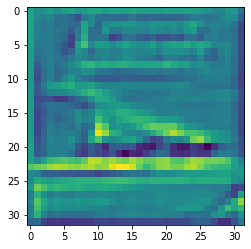

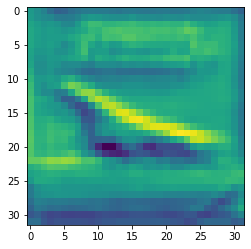

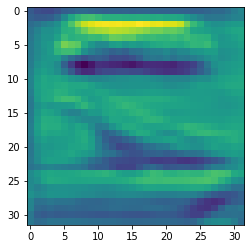

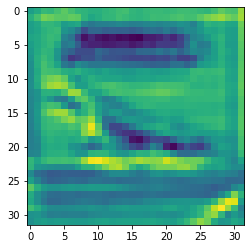

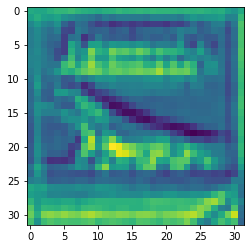

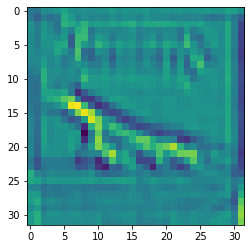

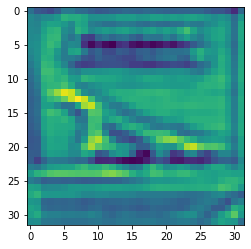

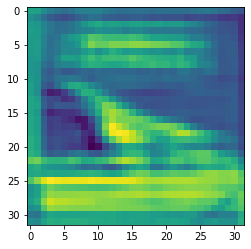

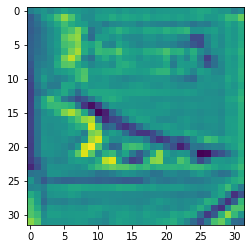

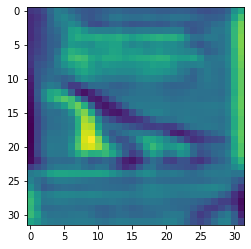

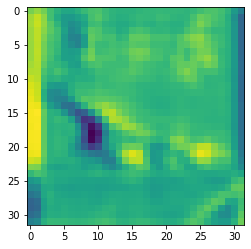

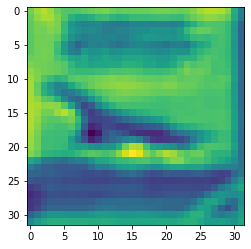

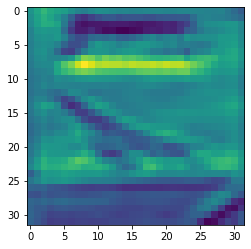

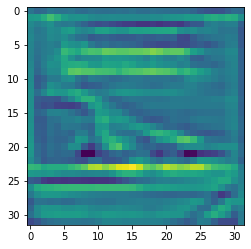

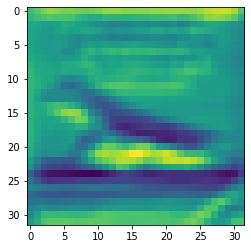

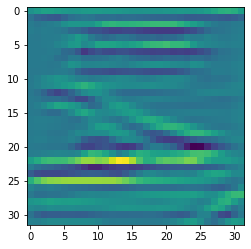

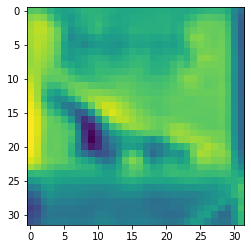

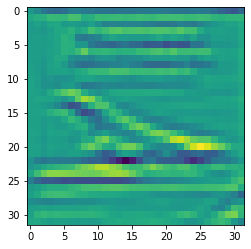

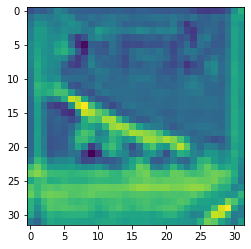

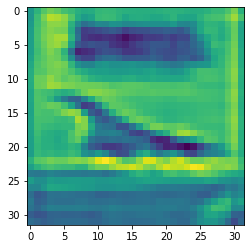

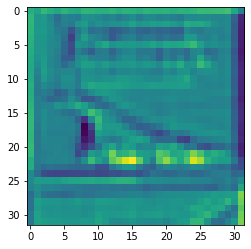

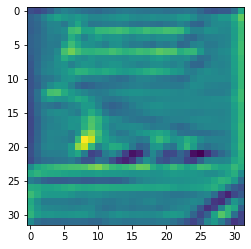

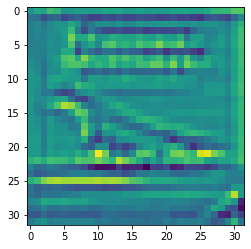

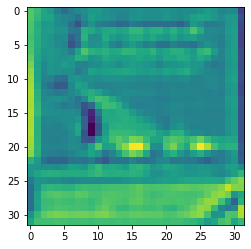

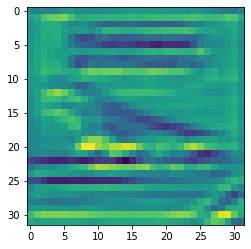

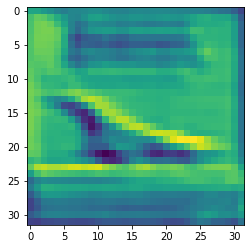

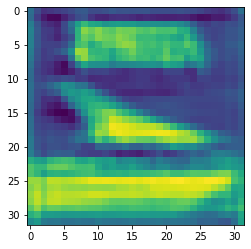

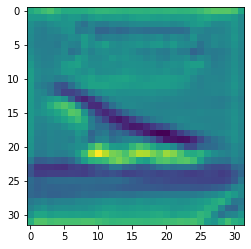

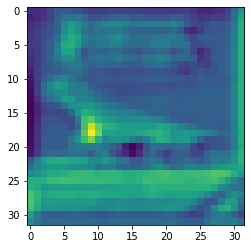

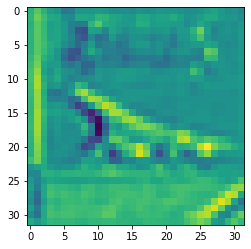

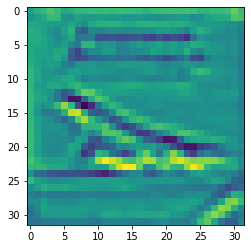

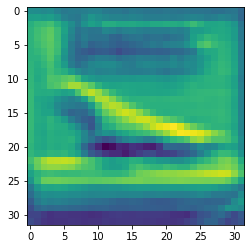

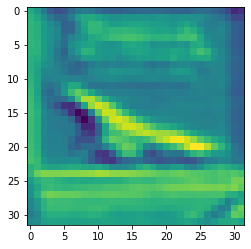

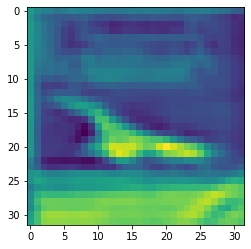

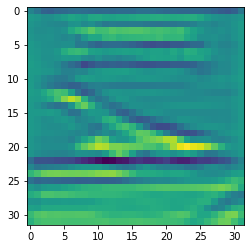

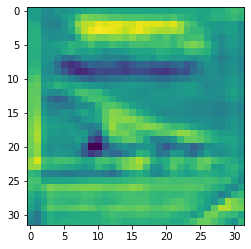

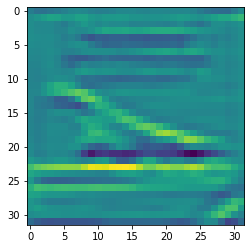

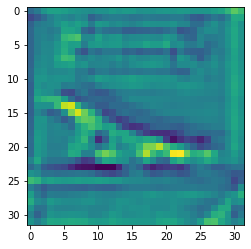

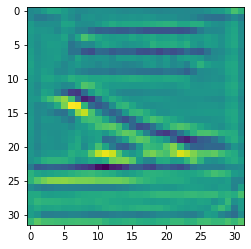

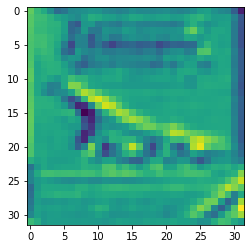

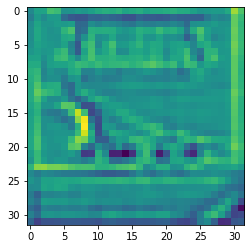

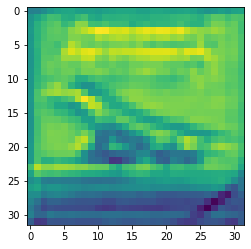

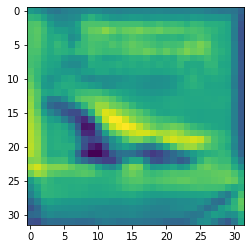

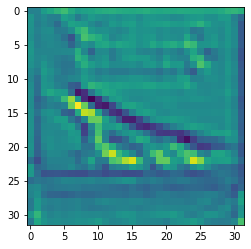

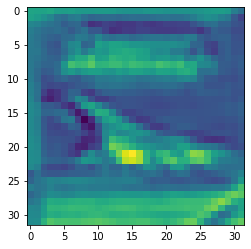

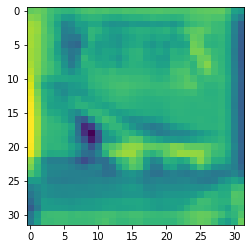

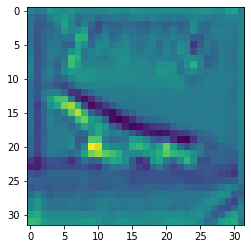

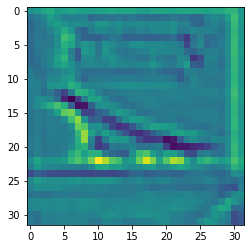

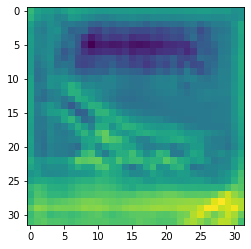

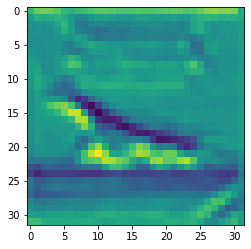

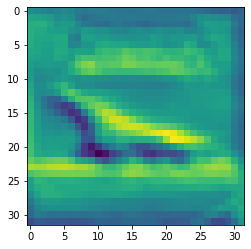

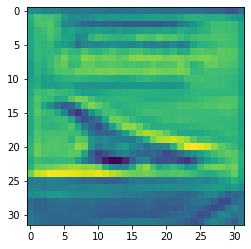

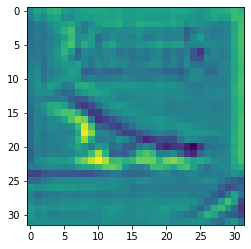

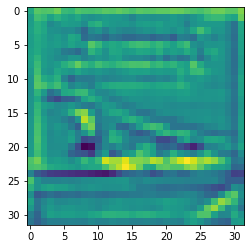

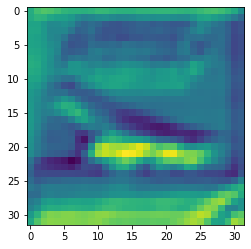

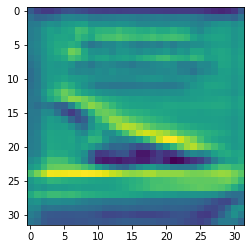

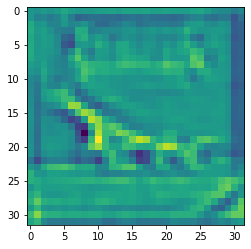

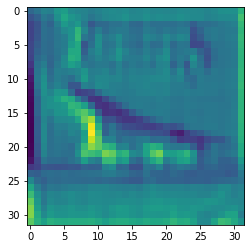

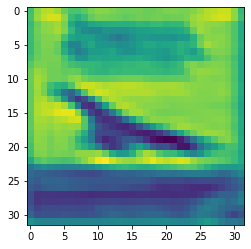

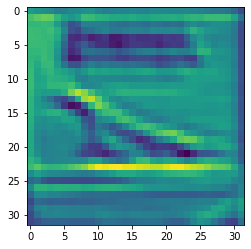

GroundTruth:    cat  ship  ship plane


In [ ]:
# Test the network on the test data, Okay, first step. Let us display an image from the test set to get familiar.
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.cuda(), labels.cuda()

fmap1 = net.get_layer_embeds(1, images).cpu().detach().numpy()
for img_no in range(fmap1.shape[0]):
    curr_img = fmap1[img_no]
    print("################FEATURE MAPS of CLASS NAME :{} ############### ".format(classes[labels[img_no]]))
    for i in range(curr_img.shape[0]):
        img = curr_img[i]
        img = img / 2 + 0.5 
        plt.imshow(img)
        plt.show()
# print(type(fmap1))
#imshow(torchvision.utils.make_grid(fmap1))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net().cuda()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)


In [ ]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data        
        images, labels = images.cuda(),labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %
